In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout
from keras.models import Model

import tensorflow as tf
import sys
sys.path.append('../src/')
import vcf2onehot

from keras.models import load_model
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import os

from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger


In [2]:
STAR_SAMPLE = '../data/final_model/star_samples.vcf'

CURATED_FUNCTION = '../data/final_model/pcbi.1008399.s003.xlsx'

PATH_LABEL_SAVE = '../data/final_model/labels_alleles.csv'

In [3]:
def get_sample_names():
    samples = []
    with open(STAR_SAMPLE) as f:
        for line in f:
            if line.startswith("#CHROM"):
                samples = line.strip().split()[9:]
                break
    return samples
    

In [4]:
def get_data() -> dict:
    samples = get_sample_names()

    seqs = vcf2onehot.build_seqs(STAR_SAMPLE)
    data = vcf2onehot.format_seqs(seqs)
    data['y'] = pd.read_csv(PATH_LABEL_SAVE, header=None, index_col=0).loc[samples].values
    
    return data
    

In [5]:
def split_data(data: dict) -> tuple:
    determined_samples = {}
    uncurated_samples ={}
    
    mask = np.all(np.isnan(data['y']) == False, axis=1)
    
    determined_samples['X'] = data['X'][mask]
    determined_samples['y'] = data['y'][mask]
    determined_samples['sample_names'] = data['sample_names'][mask]

    uncurated_samples['X'] = data['X'][~mask]
    uncurated_samples['sample_names'] = data['sample_names'][~mask]
    # print(uncurated_samples)
    uncurated_stars = np.array([s for s in uncurated_samples['sample_names'] if s.split('_')[-1] == '001'])
    uncurated_star_mask = np.isin(uncurated_samples['sample_names'], uncurated_stars)
    
    uncurated_samples['sample_names'] = uncurated_samples['sample_names'][uncurated_star_mask]
    uncurated_samples['X'] = uncurated_samples['X'][uncurated_star_mask]
    
    return determined_samples, uncurated_samples

In [6]:
def get_dataset_train_eval(determined_samples: dict) -> tuple:
    all_stars = np.array([s.split('_')[1] for s in determined_samples['sample_names']])
    stars, idx = np.unique(all_stars, return_index=True)
    train_idx, test_idx = train_test_split(idx, stratify=determined_samples['y'][idx], test_size=24, random_state=1)
    
    sample_mask = np.isin(all_stars, all_stars[train_idx])
    
    test_stars = np.array([s for s in determined_samples['sample_names'][~sample_mask] if s.split('_')[-1] == '001'])
    test_mask = np.isin(determined_samples['sample_names'], test_stars)

    train_stars = np.array([s for s in determined_samples['sample_names'][sample_mask] if s.split('_')[-1] == '001'])
    train_mask = np.isin(determined_samples['sample_names'], train_stars)
    
    
    # gồm tất cả các allele + suballele sử dụng trong quá trình trainning
    _train_X, _test_X = determined_samples['X'][sample_mask], determined_samples['X'][~sample_mask]
    _train_y, _test_y = determined_samples['y'][sample_mask], determined_samples['y'][~sample_mask]

    dataset_trainning = [(_train_X, _train_y), (_test_X, _test_y)]

    # chỉ bao gồm các allele 001 dùng để đánh giá
    star_train_X, star_test_X = determined_samples['X'][train_mask], determined_samples['X'][test_mask]
    star_train_y, star_test_y = determined_samples['y'][train_mask], determined_samples['y'][test_mask]
    
    dataset_evalution = [(star_train_X, star_train_y), (star_test_X, star_test_y)]
    
    return dataset_trainning, dataset_evalution
    
    

In [7]:
def cvtoDataset(dataset_trainning):
    
    _train_ds = tf.data.Dataset.from_tensor_slices(dataset_trainning[0])
    train_ds = _train_ds.repeat().shuffle(dataset_trainning[0][1].shape[0], reshuffle_each_iteration=True).batch(32).prefetch(buffer_size=10)

    _test_ds = tf.data.Dataset.from_tensors(dataset_trainning[1])
    test_ds = _test_ds.prefetch(buffer_size=10)
    
    return train_ds, test_ds

In [8]:
data = get_data()

In [9]:
determined_samples, uncurated_samples = split_data(data)

In [10]:
len(determined_samples['y'])

216

In [11]:
dataset_trainning, dataset_evalution = get_dataset_train_eval(determined_samples)

In [12]:
train_ds, test_ds = cvtoDataset(dataset_trainning)

In [13]:
def get_model_pretrained():
    PATH_MODEL = '../save_model/FinalModel/final_25-03-2024_02-32/model.h5'
    model = load_model(PATH_MODEL)
    return model

In [14]:
def create_transfer_model():
    model = get_model_pretrained()
    model.pop()
    model.pop()
    model.pop()
    model.trainable = False

    layer = Dense(units=32, activation='relu', name='dense5')(model.output)
    layer = Dropout(0.3, name='dropout_4')(layer)
    layer = Dense(units=1, activation='linear', name='dense6')(layer)
    outputs = Dense(units=2, activation='sigmoid')(layer)

    transfer_model = Model(inputs=model.input, outputs=outputs, name='transfer_model')
    
    return transfer_model
    

In [69]:
now = datetime.now().strftime('%d-%m-%Y_%H-%M')

tensorboard_callback = TensorBoard(log_dir=f"../model/FINAL_MODEL//TensorBoard/{now}/logs")

folder_logger_path = f"../model/FINAL_MODEL//CSVLogger/{now}"

if os.path.exists(folder_logger_path) and os.path.isdir(folder_logger_path):
    os.rmdir(folder_logger_path)
os.makedirs(folder_logger_path)

csv_logger_callback = CSVLogger(f"{folder_logger_path}/training.log")

def build_and_fit(dataset):

    model = create_transfer_model()
    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.AUC()]
              )
    
    
    model.fit(dataset, 
              steps_per_epoch=128, 
              epochs=20, 
              verbose=True,
              callbacks=[tensorboard_callback,
                         csv_logger_callback])
    
    # Fine tuning
    model.trainable = True
    model.compile(optimizer=tf.keras.optimizers.SGD(1e-5, momentum=0.8, nesterov=True),
                        loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.AUC()]
    )

    model.fit(dataset, 
              epochs=3, 
              steps_per_epoch=64, 
              verbose=True,
              callbacks=[tensorboard_callback,
                         csv_logger_callback])
    model.save(f"../model/FINAL_MODEL/FinalModel/{now}/model.h5")
    
    return model
    

In [70]:
model = create_transfer_model()
model.summary()

Model: "transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1_input (InputLayer  [(None, 14868, 13)]       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2970, 70)          17360     
                                                                 
 batch_1 (BatchNormalizatio  (None, 2970, 70)          280       
 n)                                                              
                                                                 
 relu_1 (ReLU)               (None, 2970, 70)          0         
                                                                 
 maxpooling_1 (MaxPooling1D  (None, 990, 70)           0         
 )                                                               
                                                    

In [71]:
ensemble_size = 7

for i in range(ensemble_size):
    print(f"HT_model_{i}.model.h5")
    model = build_and_fit(train_ds)

    model.save(f'../model/FINAL_MODEL/{now}/HT_model_{i}.model.h5')

HT_model_0.model.h5
Epoch 1/20
128/128 [==============================] - 8s 41ms/step - loss: 0.1480 - auc_21: 0.8789
Epoch 2/20
128/128 [==============================] - 5s 40ms/step - loss: 0.0859 - auc_21: 0.9560
Epoch 3/20
128/128 [==============================] - 5s 39ms/step - loss: 0.0699 - auc_21: 0.9703
Epoch 4/20
128/128 [==============================] - 6s 43ms/step - loss: 0.0591 - auc_21: 0.9800
Epoch 5/20
128/128 [==============================] - 7s 55ms/step - loss: 0.0530 - auc_21: 0.9843
Epoch 6/20
128/128 [==============================] - 7s 54ms/step - loss: 0.0455 - auc_21: 0.9879
Epoch 7/20
128/128 [==============================] - 7s 52ms/step - loss: 0.0432 - auc_21: 0.9886
Epoch 8/20
128/128 [==============================] - 6s 51ms/step - loss: 0.0395 - auc_21: 0.9899
Epoch 9/20
128/128 [==============================] - 7s 52ms/step - loss: 0.0372 - auc_21: 0.9904
Epoch 10/20
128/128 [==============================] - 7s 52ms/step - loss: 0.0353 - auc_

c:\anaconda3\envs\ml-hus\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/20
128/128 [==============================] - 9s 51ms/step - loss: 0.2153 - auc_23: 0.6797
Epoch 2/20
128/128 [==============================] - 7s 54ms/step - loss: 0.1833 - auc_23: 0.7505
Epoch 3/20
128/128 [==============================] - 7s 52ms/step - loss: 0.1615 - auc_23: 0.7740
Epoch 4/20
128/128 [==============================] - 7s 52ms/step - loss: 0.1398 - auc_23: 0.8746
Epoch 5/20
128/128 [==============================] - 6s 49ms/step - loss: 0.0871 - auc_23: 0.9621
Epoch 6/20
128/128 [==============================] - 7s 52ms/step - loss: 0.0590 - auc_23: 0.9787
Epoch 7/20
128/128 [==============================] - 7s 52ms/step - loss: 0.0500 - auc_23: 0.9813
Epoch 8/20
128/128 [==============================] - 7s 54ms/step - loss: 0.0449 - auc_23: 0.9837
Epoch 9/20
128/128 [==============================] - 9s 67ms/step - loss: 0.0420 - auc_23: 0.9857
Epoch 10/20
128/128 [==============================] - 7s 57ms/step - loss: 0.0391 - auc_23: 0.9872
Epoch 11/

In [57]:
class Ensemble():
    def __init__(self, X=None, dir='../model/FINAL_MODEL/'):
        self.X = X
        self.raw = None
        self.predictions = None
        self.dir = dir

        self.run()

    def run(self):
        predictions = self.predict(self.X).mean(axis=0)
        pd.DataFrame(predictions, columns=['No Function', 'Normal Function']).to_csv('../data/final_model/probs.csv', index=False)
        
        # print(predictions)
        self.raw = predictions
        self.predictions = self.get_functions(predictions)

    def get_functions(self, pred):
        # cutpoint_1 = 0.4260022
        # cutpoint_2 = 0.7360413

        cutpoint_1 = 0.743              
        cutpoint_2 = 0.77       

        cut1 = np.greater(pred[:, 0], [cutpoint_1])
        cut2 = np.greater(pred[:, 1], [cutpoint_2])
        

        functions = []
        for i in range(pred.shape[0]):
            if cut1[i] == True and cut2[i] == True:
                functions.append("Normal Function")
            elif cut1[i] == True and cut2[i] == False:
                functions.append("Decreased Function")
            else:
                functions.append("No Function")

        return np.array(functions)

    def evaluate(self, y):
        labels = self.get_functions(y)
        return np.sum(labels == self.predictions) / len(y)

    def predict(self, X):
        from glob import glob
        models = glob(self.dir + "*.model.h5")
        
        predictions = []
        print("Predicting...")
        for m in models:
        # print(f"Predicting using {m}")
            model = tf.keras.models.load_model(m)
        
            pred = model.predict(X)
            predictions.append(pred)

        return np.array(predictions)

In [58]:
def build_heatmap(pred, y, labels):
    heatmap = []
    for label in labels:
        mask = pred == label
        masked_labels = y[mask]
        heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

    return heatmap

Predicting...
1/1 [==============================] - 0s 189ms/step

Training Accuracy (only star alleles): 0.9354838709677419


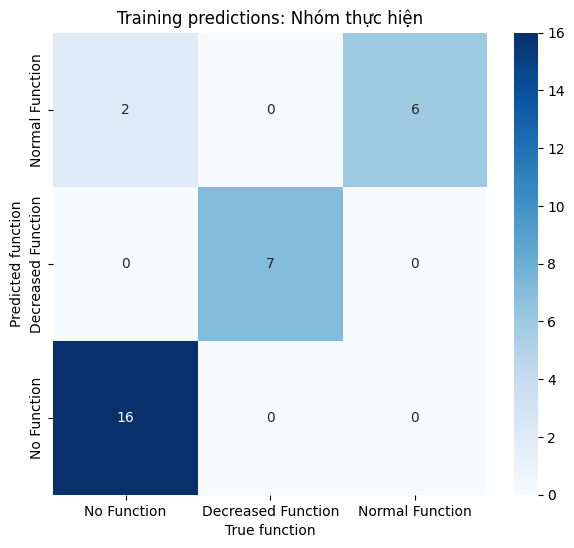

In [59]:
# Original paper attains 100% accuracy on training data star alleles
star_train_X, star_train_y = dataset_evalution[0]
# star_train_ensemble = Ensemble(star_train_X, dir='../save_model/')
star_train_ensemble = Ensemble(star_train_X)

print("\nTraining Accuracy (only star alleles):", star_train_ensemble.evaluate(star_train_y))

labels = ["Normal Function", "Decreased Function", "No Function"]

train_labels = star_train_ensemble.get_functions(star_train_y)
train_heatmap = build_heatmap(star_train_ensemble.predictions, train_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(train_heatmap, cmap="Blues", annot=train_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training predictions: Nhóm thực hiện")
plt.show()

In [60]:
train_labels

array(['Normal Function', 'No Function', 'No Function', 'No Function',
       'Decreased Function', 'No Function', 'Normal Function',
       'Normal Function', 'Decreased Function', 'No Function',
       'Normal Function', 'Normal Function', 'No Function', 'No Function',
       'Decreased Function', 'No Function', 'Normal Function',
       'No Function', 'Decreased Function', 'No Function',
       'Decreased Function', 'No Function', 'No Function', 'No Function',
       'No Function', 'No Function', 'No Function', 'No Function',
       'Decreased Function', 'No Function', 'Decreased Function'],
      dtype='<U18')

In [61]:
star_train_ensemble.predictions

array(['Normal Function', 'No Function', 'No Function', 'No Function',
       'Decreased Function', 'Normal Function', 'Normal Function',
       'Normal Function', 'Decreased Function', 'No Function',
       'Normal Function', 'Normal Function', 'Normal Function',
       'No Function', 'Decreased Function', 'No Function',
       'Normal Function', 'No Function', 'Decreased Function',
       'No Function', 'Decreased Function', 'No Function', 'No Function',
       'No Function', 'No Function', 'No Function', 'No Function',
       'No Function', 'Decreased Function', 'No Function',
       'Decreased Function'], dtype='<U18')

Predicting...
2/2 [==============================] - 0s 22ms/step

Test Accuracy + suballeles: 0.8070175438596491


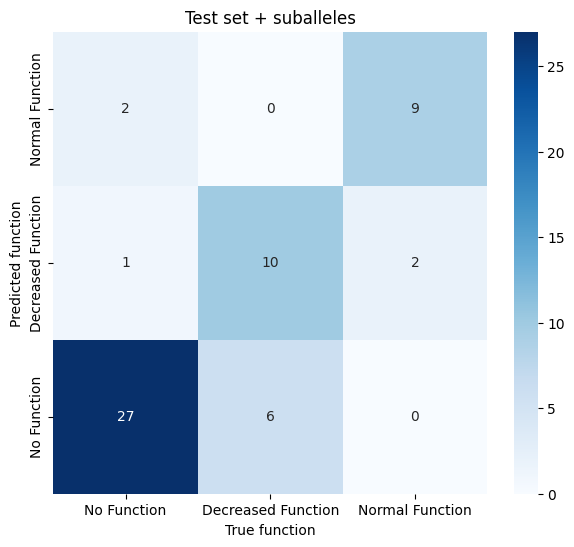

In [62]:
# All test star alleles + suballeles
test_X, test_y = dataset_trainning[1]
test_ensemble = Ensemble(test_X)
test_labels = test_ensemble.get_functions(test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Test set + suballeles")

print("\nTest Accuracy + suballeles:", test_ensemble.evaluate(test_y))

In [183]:
df = pd.read_csv('../data/final_model/probs.csv')
df['Origin_label_1'] = test_y[:, 0]
df['Origin_label_2'] = test_y[:, 1]

df['Origin_label_1'] = df['Origin_label_1'].replace({0: 'N', 1: 'Y'})
df['Origin_label_2'] = df['Origin_label_2'].replace({0: 'N', 1: 'Y'})
df.to_csv('../data/final_model/probs_test.csv', index=False)

Predicting...
1/1 [==============================] - 0s 172ms/step

Test Accuracy: 0.875


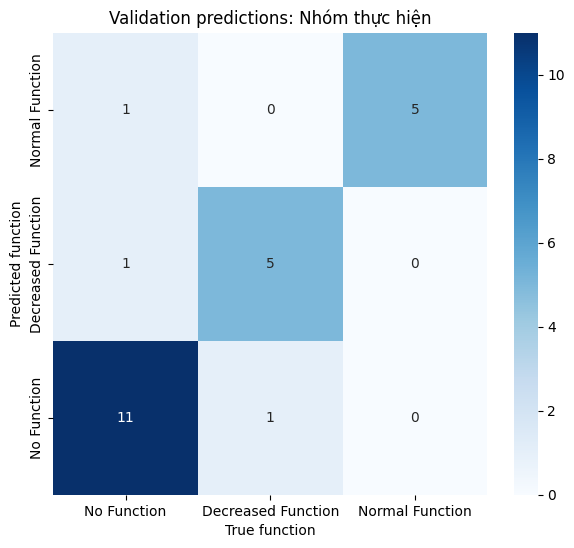

In [48]:
# All test star alleles
star_test_X, star_test_y = dataset_evalution[1]
test_ensemble = Ensemble(star_test_X)
print("\nTest Accuracy:", test_ensemble.evaluate(star_test_y))


test_labels = test_ensemble.get_functions(star_test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Validation predictions: Nhóm thực hiện")
plt.show()

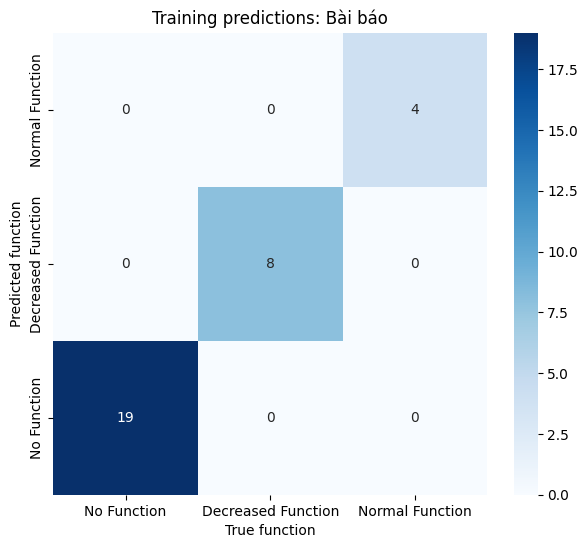

In [130]:
pred = np.array(["No Function"]*19 + ["Decreased Function"]*8 + ["Normal Function"]*4)
truth = np.array(["No Function"]*19 + ["Decreased Function"]*8 + ["Normal Function"]*4)

test_heatmap = build_heatmap(pred, truth, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training predictions: Bài báo")
plt.show()

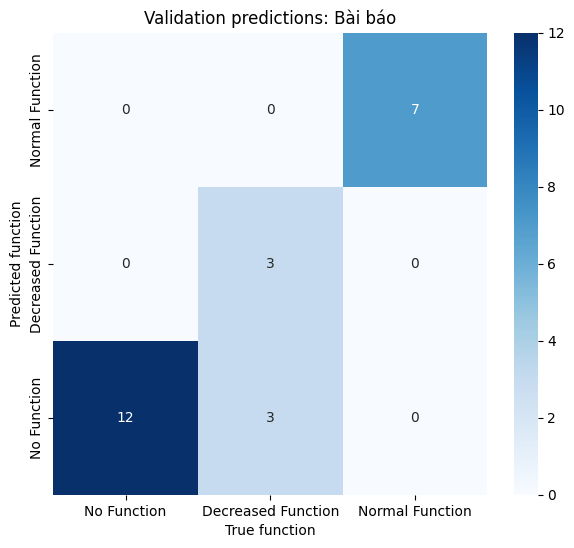

In [133]:
pred = np.array(["No Function"]*15 + ["Decreased Function"]*3 + ["Normal Function"]*7)
truth = np.array(["No Function"]*12 + ["Decreased Function"]*6 + ["Normal Function"]*7)

test_heatmap = build_heatmap(pred, truth, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Validation predictions: Bài báo")
plt.show()

In [50]:
# predict = pd.read_csv('../data/final_model/uncurated/predict.csv')
# predict

In [52]:
predict_ubncertain_labels = Ensemble(uncurated_samples['X'])

Predicting...
3/3 [==============================] - 0s 23ms/step


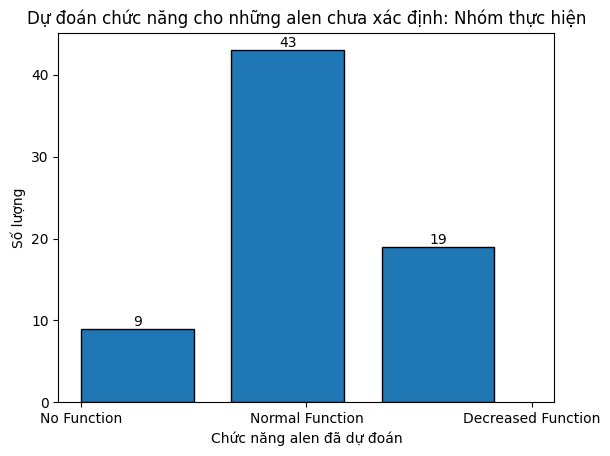

In [53]:
counts, edges, bars = plt.hist(predict_ubncertain_labels.predictions
, bins=3, edgecolor='black', width=0.5)
plt.bar_label(bars)

plt.xlabel('Chức năng alen đã dự đoán')
plt.ylabel('Số lượng')
plt.title('Dự đoán chức năng cho những alen chưa xác định: Nhóm thực hiện')
plt.show()

In [163]:
CURATED_FUNCTION = '../data/final_model/pcbi.1008399.s003.xlsx'
pred_hubble2d6 = pd.read_excel(CURATED_FUNCTION)

In [173]:
pred_hubble2d6 = pred_hubble2d6.loc[pred_hubble2d6['Curated Function'] == 'Uncurated']

In [174]:
pred_hubble2d6

,CYP2D6 Star Allele,Curated Function,Hubble Predicted Function
19,*22,Uncurated,Decreased function
20,*23,Uncurated,Normal
21,*24,Uncurated,Normal
22,*25,Uncurated,Normal
23,*26,Uncurated,Normal
...,...,...,...
122,*135,Uncurated,Normal
123,*136,Uncurated,Normal
124,*137,Uncurated,Normal
125,*138,Uncurated,No function


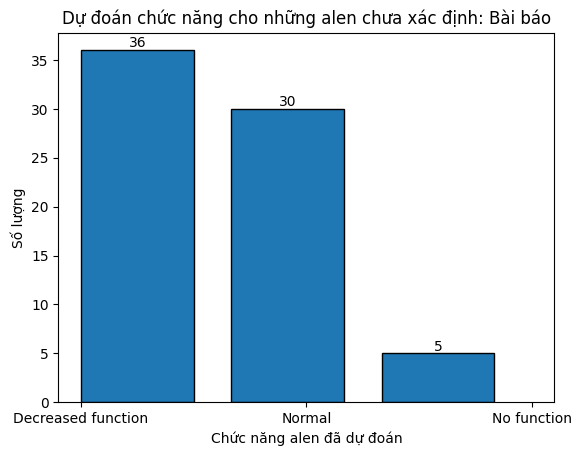

In [179]:


counts, edges, bars = plt.hist(pred_hubble2d6['Hubble Predicted Function'], bins=3, edgecolor='black', width=0.5)
plt.bar_label(bars)

plt.xlabel('Chức năng alen đã dự đoán')
plt.ylabel('Số lượng')
plt.title('Dự đoán chức năng cho những alen chưa xác định: Bài báo')
plt.show()